## Loading the dataset

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the raw file you downloaded
RAW_CSV = "/Users/taraapple/Downloads/pp-monthly-update-new-version.csv"        
# Official column order for Price Paid Data
cols = [
    "transaction_id",        # 0  Transaction unique identifier
    "price",                 # 1  Price paid (£)
    "date_of_transfer",      # 2  Transfer date
    "postcode",              # 3  Full postcode
    "property_type",         # 4  D=Detached, S=Semi, T=Terrace, F=Flat, O=Other
    "old_new",               # 5  Y=New build, N=Established
    "duration",              # 6  F=Freehold, L=Leasehold
    "paon",                  # 7  Primary addressable object name
    "saon",                  # 8  Secondary addressable object name
    "street",                # 9  Street
    "locality",              # 10 Locality
    "town_city",             # 11 Town or city
    "district",              # 12 District
    "county",                # 13 County
    "ppd_category",          # 14 A=Standard, B=Additional
    "record_status"          # 15 A=Added, C=Changed, D=Deleted
]

# Load the data with correct column names
df = pd.read_csv(
    RAW_CSV,
    header=None,          # no header in file
    names=cols,           # attach column names
    parse_dates=[2],      # parse 'date_of_transfer'
    low_memory=False
)

# Quick check
print(df.head())
print(df.info())

                           transaction_id   price date_of_transfer  postcode  \
0  {34222871-EE22-4D2B-E063-4704A8C07853}  176000       2004-10-08  BS22 8ED   
1  {34222871-F53F-4D2B-E063-4704A8C07853}  522000       2004-06-04  RG40 4HE   
2  {34222871-F6A5-4D2B-E063-4704A8C07853}  134000       2004-06-28   RG1 6QR   
3  {34222871-F6D5-4D2B-E063-4704A8C07853}  249999       2004-11-24   SL4 1HX   
4  {34222872-1FCC-4D2B-E063-4704A8C07853}  255000       2004-11-21  EX20 4AZ   

  property_type old_new duration             paon     saon  \
0             S       N        F                1      NaN   
1             D       N        F               19      NaN   
2             F       N        L  CHARNWOOD HOUSE  FLAT 18   
3             S       N        F               33      NaN   
4             D       N        F          LYDGATE      NaN   

               street       locality          town_city  \
0    SOMERDALE AVENUE            NaN  WESTON-SUPER-MARE   
1     NASH GROVE LANE  FINCH

## Remove Duplicates

In [3]:
df = df.drop_duplicates()

## Feature Engineering (Postcode)

In [4]:
import re

df.columns = [
    "transaction_id",        # 0  Transaction unique identifier
    "price",                 # 1  Price paid (£)
    "date_of_transfer",      # 2  Transfer date
    "postcode",              # 3  Full postcode
    "property_type",         # 4  D=Detached, S=Semi, T=Terrace, F=Flat, O=Other
    "old_new",               # 5  Y=New build, N=Established
    "duration",              # 6  F=Freehold, L=Leasehold
    "paon",                  # 7  Primary addressable object name
    "saon",                  # 8  Secondary addressable object name
    "street",                # 9  Street
    "locality",              # 10 Locality
    "town_city",             # 11 Town or city
    "district",              # 12 District
    "county",                # 13 County
    "ppd_category",          # 14 A=Standard, B=Additional
    "record_status"          # 15 A=Added, C=Changed, D=Deleted
]

def extract_number_from_postcode(postcode):
    if isinstance(postcode, str):
        first_segment = postcode.split()[0]  # e.g., 'BS16' from 'BS16 1AG'
        match = re.search(r'\d+', first_segment)
        return int(match.group()) if match else None
    return None

# Apply the function to extract numbers
df['postcode_number'] = df['postcode'].apply(extract_number_from_postcode)

# Show sample results
df[['postcode', 'postcode_number']].head()

,postcode,postcode_number
0,BS22 8ED,22.0
1,RG40 4HE,40.0
2,RG1 6QR,1.0
3,SL4 1HX,4.0
4,EX20 4AZ,20.0


## Map Catgeorical Variables

In [5]:
# Convert date
df['date_of_transfer'] = pd.to_datetime(df['date_of_transfer'])
df['year'] = df['date_of_transfer'].dt.year
df['month'] = df['date_of_transfer'].dt.month
df['quarter'] = df['date_of_transfer'].dt.quarter
df['day_of_week'] = df['date_of_transfer'].dt.dayofweek

In [6]:
df['is_new'] = (df['old_new'] == 'Y').astype(int)
df['is_freehold'] = (df['duration'] == 'F').astype(int)
df['is_additional_property'] = (df['ppd_category'] == 'B').astype(int)

In [7]:
# Standardize and map duration codes
df['duration'] = df['duration'].str.upper().map({
    'F': 'Freehold',
    'L': 'Leasehold'
})

df['duration'] = df['duration'].fillna('Unknown')

print(df['duration'].value_counts())

duration
Freehold     71704
Leasehold    22544
Name: count, dtype: int64


In [8]:
# Map property types
property_type_map = {
    'D': 'Detached',
    'S': 'Semi-Detached',
    'T': 'Terraced',
    'F': 'Flat/Maisonette',
    'O': 'Other'
}
df['property_type'] = df['property_type'].map(property_type_map)


# Convert others to category type
df['old_new'] = df['old_new'].map({'Y': 'New', 'N': 'Old'}).astype('category')
df['duration'] = df['duration'].astype('category')
df['property_type'] = df['property_type'].astype('category')

In [9]:
# Convert to categorical types
df['record_status'] = df['record_status'].astype('category')
df['ppd_category'] = df['ppd_category'].astype('category')

# Optionally, rename categories for clarity
df['record_status'] = df['record_status'].cat.rename_categories({
    'A': 'Added',
    'C': 'Changed',
    'D': 'Deleted'
})

df['ppd_category'] = df['ppd_category'].cat.rename_categories({
    'A': 'Standard',
    'B': 'Additional'
})

In [10]:
df.isnull().sum()
# Percentage of missing values
(df.isnull().mean() * 100).sort_values(ascending=False)

saon                      85.455394
locality                  61.239496
street                     1.635048
postcode                   0.314065
postcode_number            0.314065
transaction_id             0.000000
ppd_category               0.000000
is_freehold                0.000000
is_new                     0.000000
day_of_week                0.000000
quarter                    0.000000
month                      0.000000
year                       0.000000
record_status              0.000000
district                   0.000000
county                     0.000000
price                      0.000000
town_city                  0.000000
paon                       0.000000
duration                   0.000000
old_new                    0.000000
property_type              0.000000
date_of_transfer           0.000000
is_additional_property     0.000000
dtype: float64

In [11]:
df = df.dropna(subset=['postcode', 'price'])

In [12]:
import pandas as pd

# Make a copy to avoid modifying original
df['paon'] = df['paon'].astype(str).str.strip()

# 1. Is PAON numeric (only digits)?
df['paon_is_numeric'] = df['paon'].str.fullmatch(r'\d+').fillna(False)

# 2. Extract first number in PAON (if any)
df['paon_number'] = df['paon'].str.extract(r'(\d+)').astype(float)

# 3. Is it a number range? (e.g., '12-14')
df['paon_is_range'] = df['paon'].str.contains(r'\d+\s*-\s*\d+', na=False)

# 4. Is it a named property (non-numeric)?
df['paon_is_named'] = ~df['paon'].str.contains(r'\d', na=False)

# 5. Length of PAON (could relate to naming style)
df['paon_length'] = df['paon'].str.len()

# 6. Starts with a digit? Useful for differentiating flats vs. names
df['paon_starts_digit'] = df['paon'].str.match(r'^\d')

# 7. PAON prefix (e.g., first letter or number)
df['paon_prefix'] = df['paon'].str.extract(r'^([A-Za-z]|\d+)')

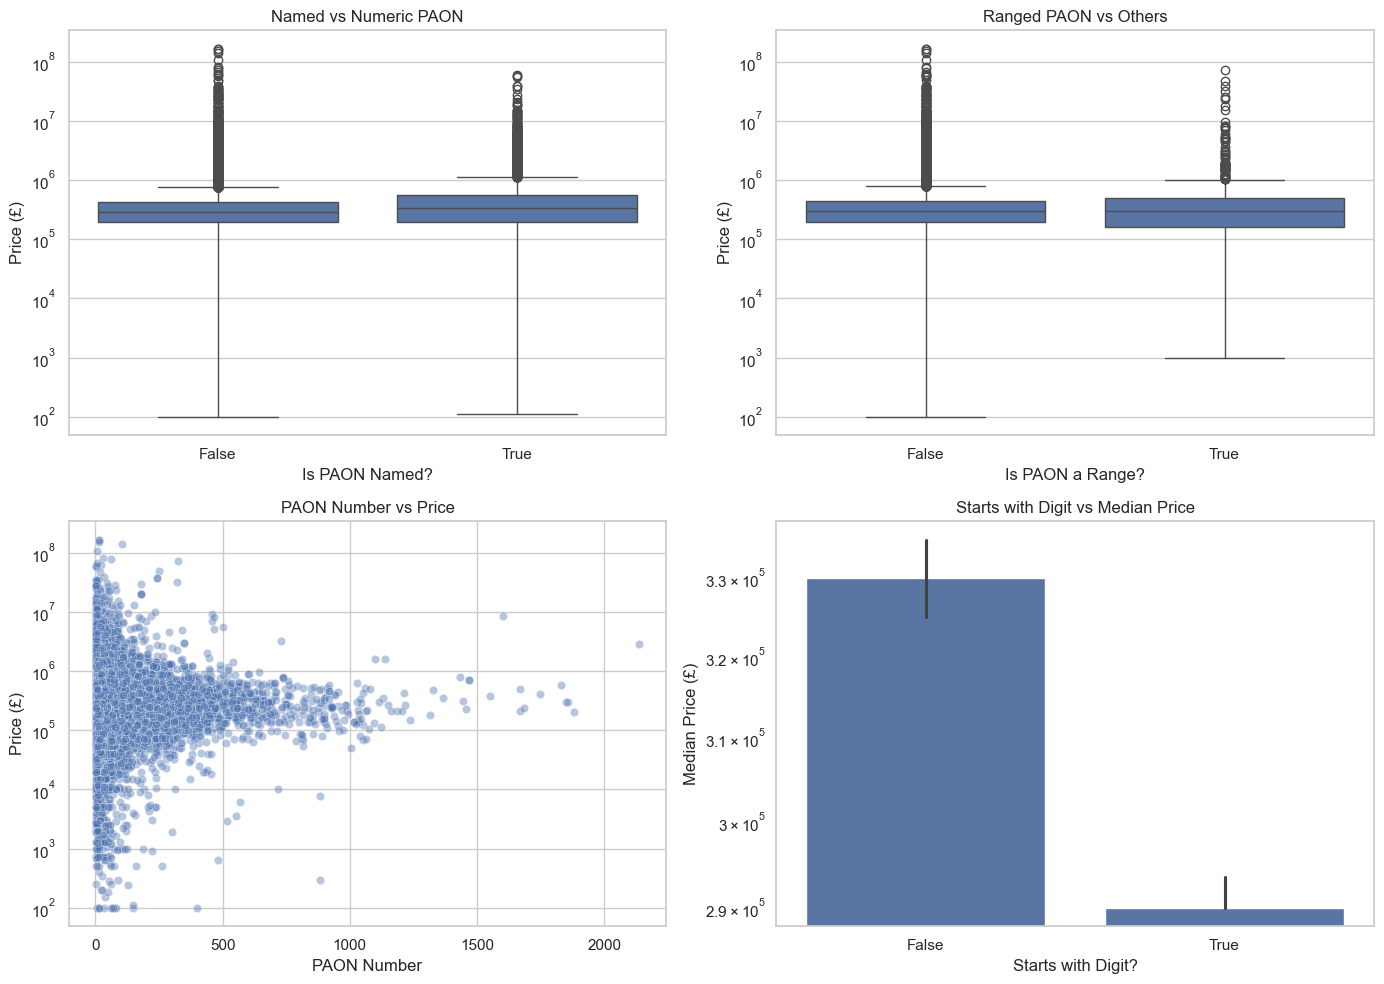

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style='whitegrid')

# Create the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: Price vs paon_is_named ---
sns.boxplot(ax=axes[0, 0], x='paon_is_named', y='price', data=df)
axes[0, 0].set_title('Named vs Numeric PAON')
axes[0, 0].set_xlabel('Is PAON Named?')
axes[0, 0].set_ylabel('Price (£)')
axes[0, 0].set_yscale('log')

# --- Plot 2: Price vs paon_is_range ---
sns.boxplot(ax=axes[0, 1], x='paon_is_range', y='price', data=df)
axes[0, 1].set_title('Ranged PAON vs Others')
axes[0, 1].set_xlabel('Is PAON a Range?')
axes[0, 1].set_ylabel('Price (£)')
axes[0, 1].set_yscale('log')

# --- Plot 3: PAON Number vs Price ---
sns.scatterplot(ax=axes[1, 0], x='paon_number', y='price', data=df, alpha=0.4)
axes[1, 0].set_title('PAON Number vs Price')
axes[1, 0].set_xlabel('PAON Number')
axes[1, 0].set_ylabel('Price (£)')
axes[1, 0].set_yscale('log')

# --- Plot 4: PAON Starts with Digit vs Median Price ---
sns.barplot(ax=axes[1, 1], x='paon_starts_digit', y='price', data=df, estimator='median')
axes[1, 1].set_title('Starts with Digit vs Median Price')
axes[1, 1].set_xlabel('Starts with Digit?')
axes[1, 1].set_ylabel('Median Price (£)')
axes[1, 1].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()


Named Properties:
count    10991.000000
mean        12.717612
std          0.912137
min          4.727388
25%         12.185875
50%         12.721889
75%         13.235694
max         17.893048
Name: log_price, dtype: float64

Numeric Properties:
count    82961.000000
mean        12.559187
std          0.727375
min          4.615121
25%         12.180760
50%         12.587931
75%         12.959847
max         18.917205
Name: log_price, dtype: float64


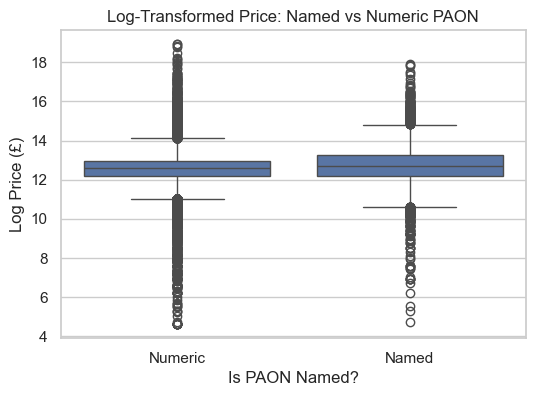


Mann-Whitney U Test Results:
U statistic: 507903074.00
P-value: 0.00000
✅ Statistically significant difference in price between named and numeric properties.


In [14]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure log transformation for skewed price
df['log_price'] = np.log1p(df['price'])

# Group by named vs numeric
named = df[df['paon_is_named'] == True]['log_price']
numeric = df[df['paon_is_named'] == False]['log_price']

# Print summary stats
print("Named Properties:")
print(named.describe())
print("\nNumeric Properties:")
print(numeric.describe())

# Boxplot comparison
plt.figure(figsize=(6, 4))
sns.boxplot(x='paon_is_named', y='log_price', data=df)
plt.title('Log-Transformed Price: Named vs Numeric PAON')
plt.xlabel('Is PAON Named?')
plt.ylabel('Log Price (£)')
plt.xticks([0, 1], ['Numeric', 'Named'])
plt.show()

# Mann-Whitney U test (non-parametric test for difference in distributions)
stat, p = mannwhitneyu(named, numeric, alternative='two-sided')

print(f"\nMann-Whitney U Test Results:")
print(f"U statistic: {stat:.2f}")
print(f"P-value: {p:.5f}")

if p < 0.05:
    print("✅ Statistically significant difference in price between named and numeric properties.")
else:
    print("⚠️ No statistically significant difference in price between named and numeric properties.")


## Bar charts for each categorical column

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/3259453265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=series.name, order=order, palette='pastel')


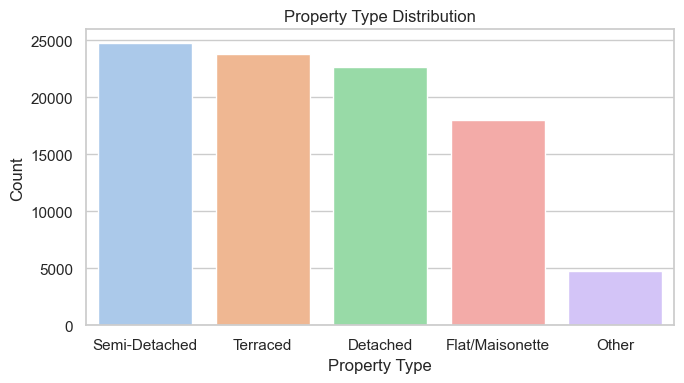

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/3259453265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=series.name, order=order, palette='pastel')


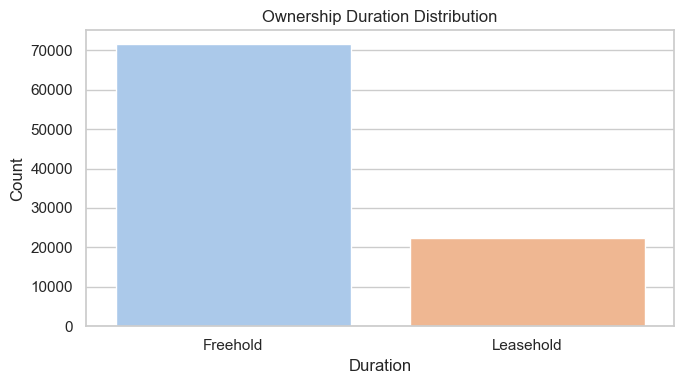

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/3259453265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=series.name, order=order, palette='pastel')


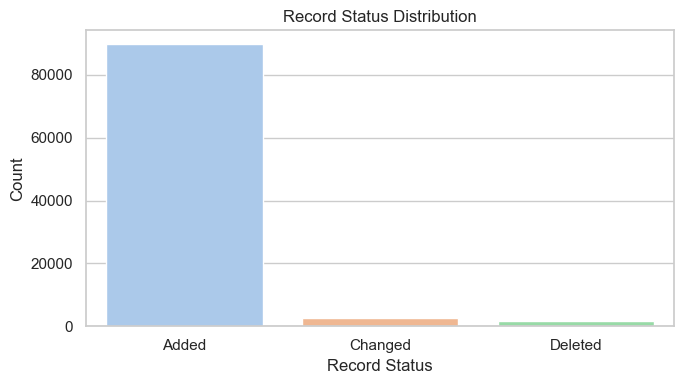

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/3259453265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=series.name, order=order, palette='pastel')


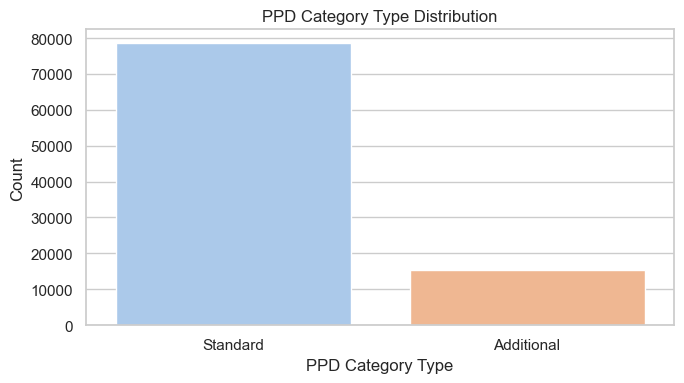

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Apply seaborn theme
sns.set(style="whitegrid")

# Helper function to draw bar plot
def seaborn_barplot(series, title, xlabel, ylabel='Count'):
    plt.figure(figsize=(7, 4))
    order = series.value_counts().index
    sns.countplot(data=df, x=series.name, order=order, palette='pastel')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot bar charts for each categorical column
seaborn_barplot(df['property_type'], 'Property Type Distribution', 'Property Type')
seaborn_barplot(df['duration'], 'Ownership Duration Distribution', 'Duration')
seaborn_barplot(df['record_status'], 'Record Status Distribution', 'Record Status')
seaborn_barplot(df['ppd_category'], 'PPD Category Type Distribution', 'PPD Category Type')


## Histogram for Price

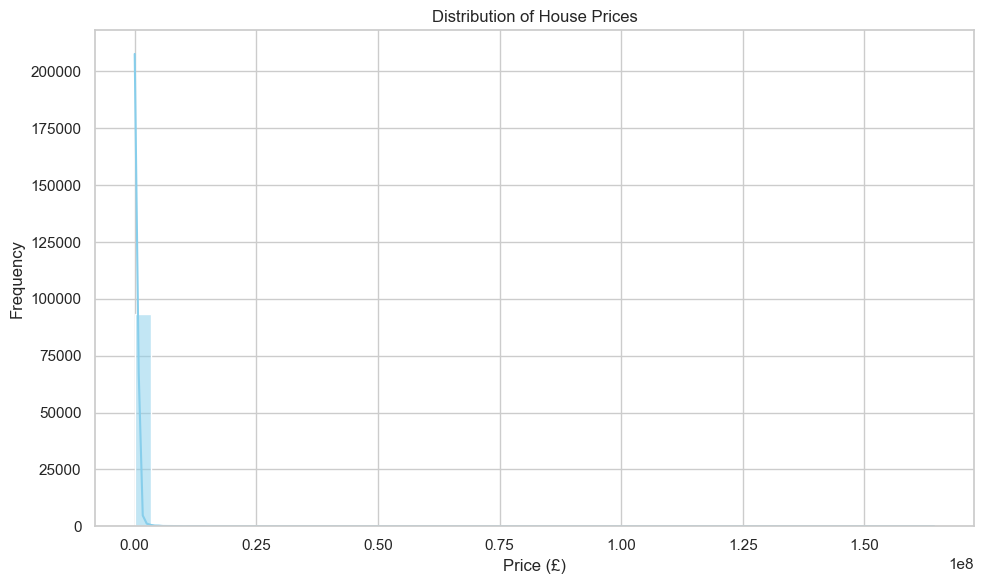

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

# Draw histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', bins=50, kde=True, color='skyblue')

# Customize labels and title
plt.title('Distribution of House Prices')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

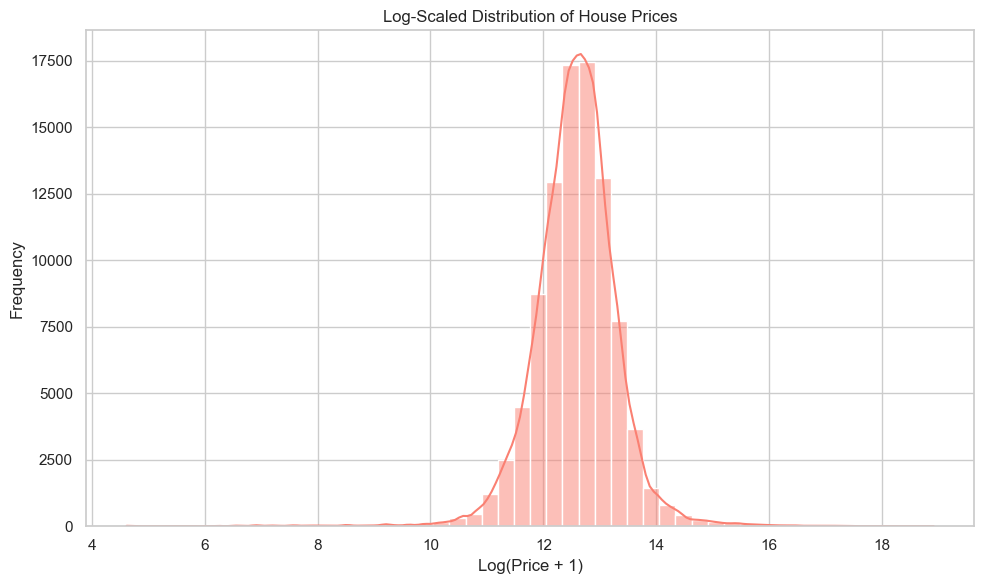

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['price']), bins=50, kde=True, color='salmon')
plt.title('Log-Scaled Distribution of House Prices')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/2355521367.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='postcode_area', y='price', palette='Set3')


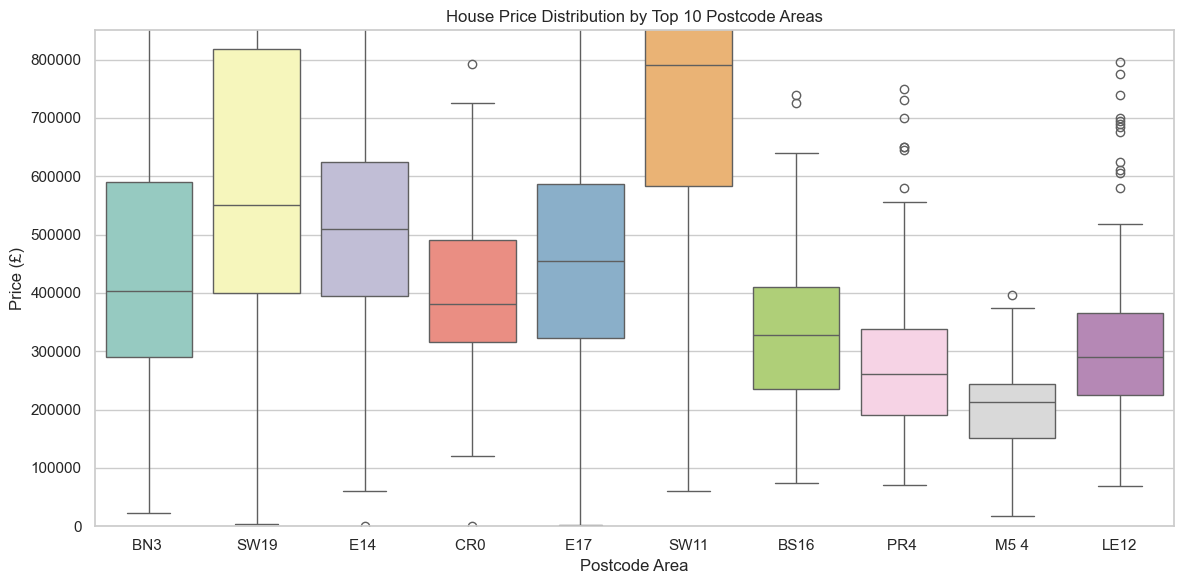

In [18]:
# Create new column with first 4 characters of postcode
df['postcode_area'] = df['postcode'].str[:4]

# Get top 10 most frequent postcode areas
top_postcodes = df['postcode_area'].value_counts().head(10).index

# Filter dataset for top postcodes
filtered_df = df[df['postcode_area'].isin(top_postcodes)]

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.boxplot(data=filtered_df, x='postcode_area', y='price', palette='Set3')

plt.title("House Price Distribution by Top 10 Postcode Areas")
plt.xlabel("Postcode Area")
plt.ylabel("Price (£)")
plt.ylim(0, df['price'].quantile(0.95))  # remove top 5% outliers

plt.tight_layout()
plt.show()

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/4166826319.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='county', y='price', palette='Set3')


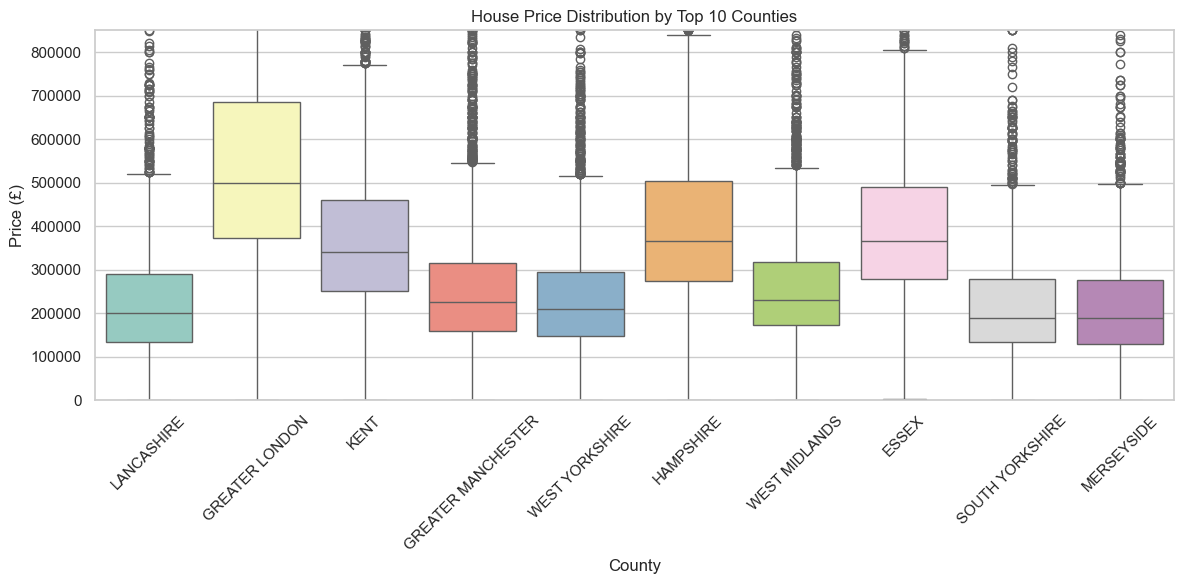

In [19]:
# Get top 10 most frequent counties
top_counties = df['county'].value_counts().head(10).index

# Filter dataset for top counties
filtered_df = df[df['county'].isin(top_counties)]

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.boxplot(data=filtered_df, x='county', y='price', palette='Set3')

plt.title("House Price Distribution by Top 10 Counties")
plt.xlabel("County")
plt.ylabel("Price (£)")
plt.ylim(0, df['price'].quantile(0.95))  # remove top 5% outliers
plt.xticks(rotation=45)  # rotate x-axis labels

plt.tight_layout()
plt.show()

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/267065364.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='town_city', y='price', palette='Set3')


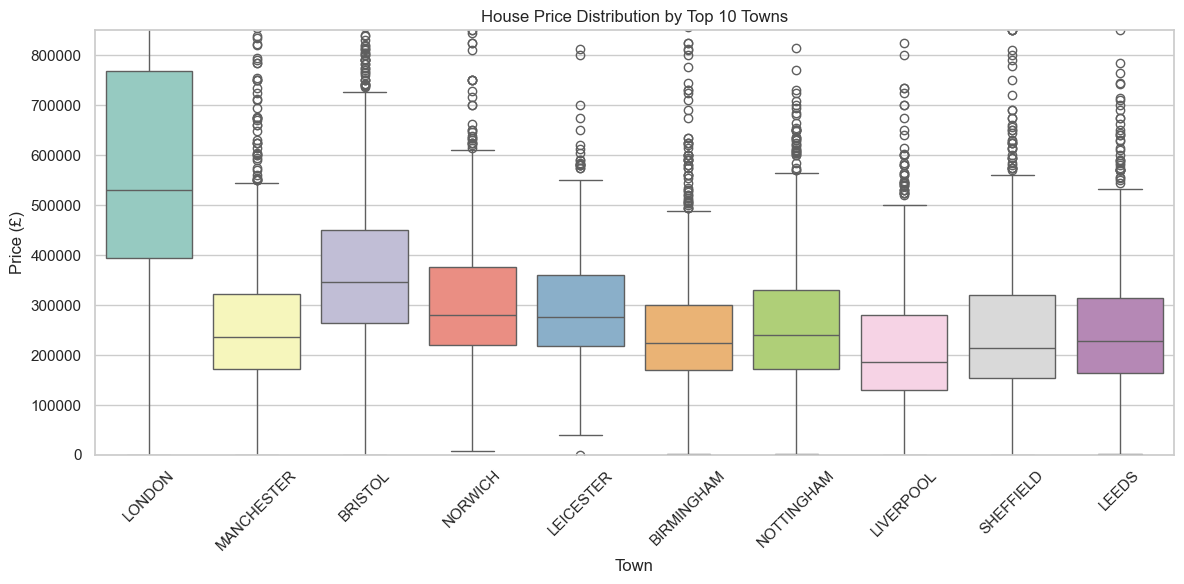

In [20]:
# Get top 10 most frequent towns
top_towns = df['town_city'].value_counts().head(10).index

# Filter dataset for top towns
filtered_df = df[df['town_city'].isin(top_towns)]

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.boxplot(data=filtered_df, x='town_city', y='price', palette='Set3')

plt.title("House Price Distribution by Top 10 Towns")
plt.xlabel("Town")
plt.ylabel("Price (£)")
plt.ylim(0, df['price'].quantile(0.95))  # remove top 5% outliers
plt.xticks(rotation=45)  # rotate x-axis labels

plt.tight_layout()
plt.show()

## Correlation between categorical variables

In [21]:
from scipy.stats import chi2_contingency
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [22]:
categorical_cols = df.select_dtypes(include='category').columns.tolist()
cramers_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        confusion_matrix = pd.crosstab(df[col1], df[col2])
        cramers_results.loc[col1, col2] = cramers_v(confusion_matrix)
        
cramers_results = cramers_results.astype(float)

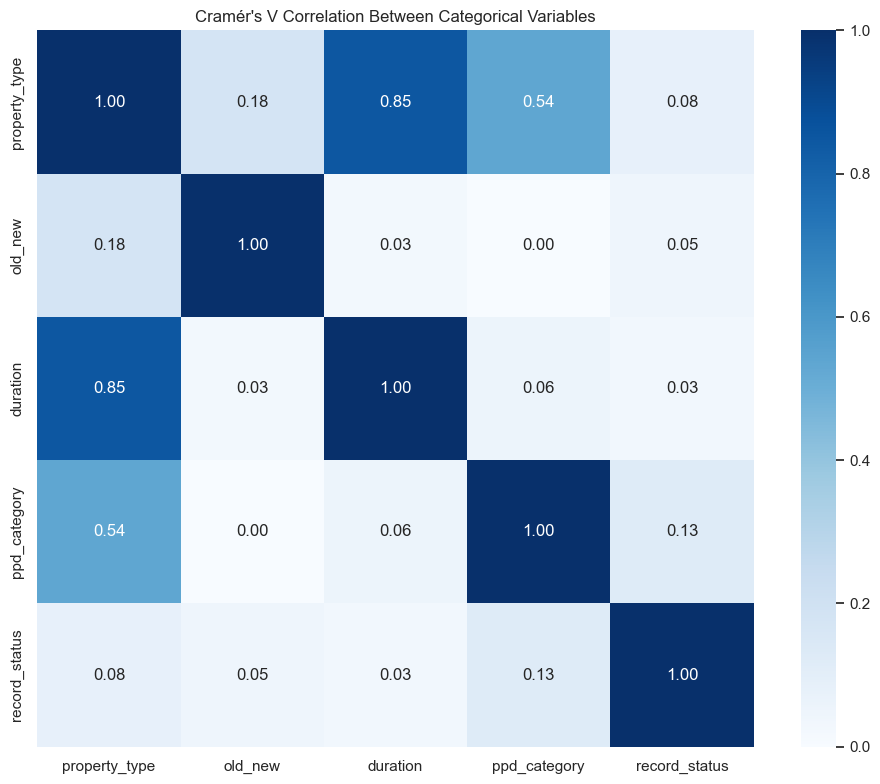

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, cmap='Blues', square=True, fmt='.2f')
plt.title("Cramér's V Correlation Between Categorical Variables")
plt.tight_layout()
plt.show()

## ANOVA

Let's compare the impact of property_type and duration on house prices using ANOVA (Analysis of Variance). This will help you decide which variable is more informative for modeling.

In [24]:
from scipy.stats import f_oneway

groups_property = [group['price'].values for name, group in df.groupby('property_type')]
f_stat_prop, p_val_prop = f_oneway(*groups_property)

print("ANOVA for property_type:")
print(f"F-statistic: {f_stat_prop:.2f}, p-value: {p_val_prop:.5f}")

ANOVA for property_type:
F-statistic: 599.73, p-value: 0.00000


/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/4247479719.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_property = [group['price'].values for name, group in df.groupby('property_type')]


In [25]:
groups_duration = [group['price'].values for name, group in df.groupby('duration')]
f_stat_dur, p_val_dur = f_oneway(*groups_duration)

print("\nANOVA for duration:")
print(f"F-statistic: {f_stat_dur:.2f}, p-value: {p_val_dur:.5f}")


ANOVA for duration:
F-statistic: 41.03, p-value: 0.00000


/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/3503416820.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_duration = [group['price'].values for name, group in df.groupby('duration')]


In [26]:
# Drop 'duration' from the dataset
df = df.drop(columns=['duration'])

Higher F-statistic → more variation in price explained by the variable.

In [27]:
groups_ppd_category = [group['price'].values for name, group in df.groupby('ppd_category')]
f_stat_prop, p_val_prop = f_oneway(*groups_property)

print("ANOVA for ppd_category:")
print(f"F-statistic: {f_stat_prop:.2f}, p-value: {p_val_prop:.5f}")

ANOVA for ppd_category:
F-statistic: 599.73, p-value: 0.00000


/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/3341807523.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_ppd_category = [group['price'].values for name, group in df.groupby('ppd_category')]


## Barplot

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col)['price'].mean().reset_index()
/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='price', order=sorted_order, palette='Set2')


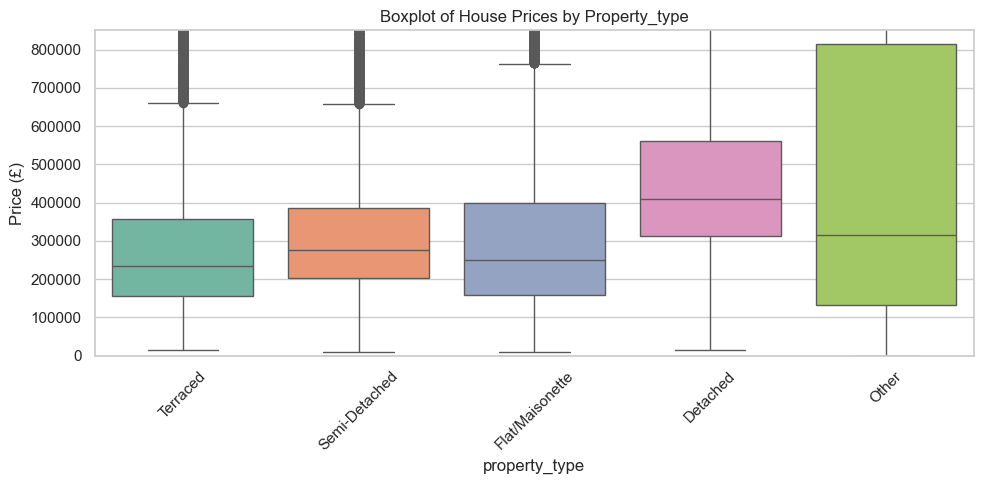

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col)['price'].mean().reset_index()
/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='price', order=sorted_order, palette='Set2')


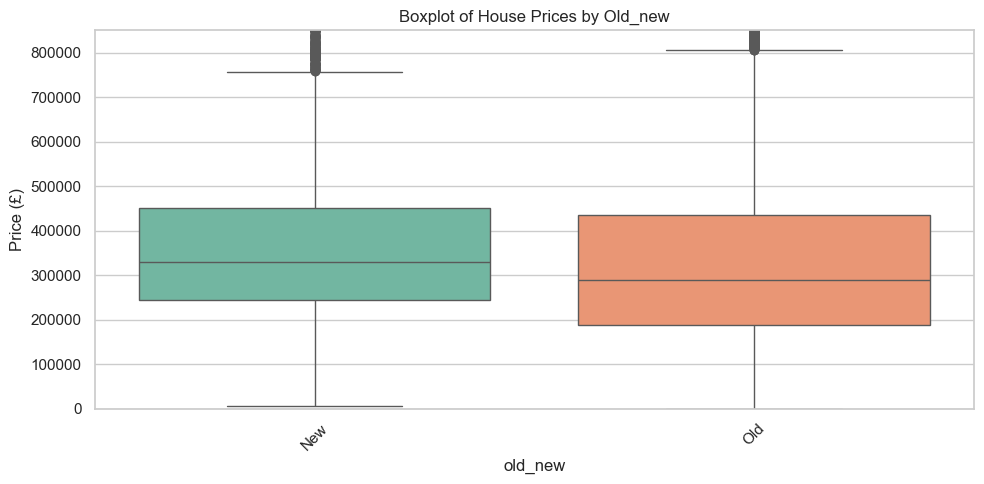

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col)['price'].mean().reset_index()
/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='price', order=sorted_order, palette='Set2')


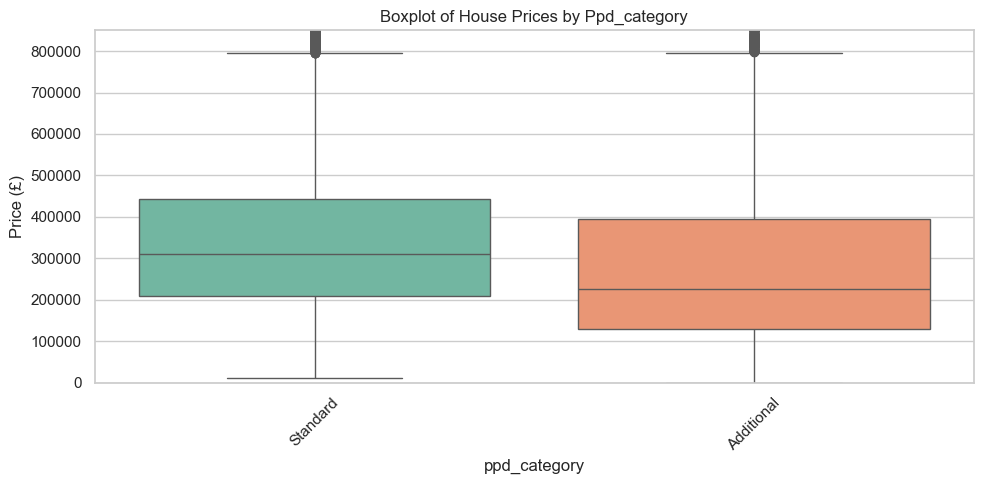

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col)['price'].mean().reset_index()
/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_849/1150948643.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='price', order=sorted_order, palette='Set2')


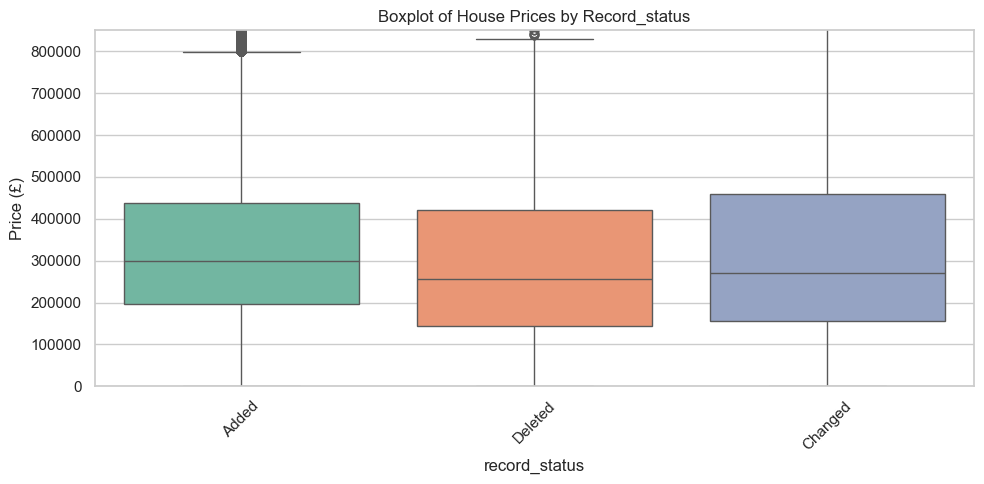

In [28]:
categorical_cols = df.select_dtypes(include='category').columns.tolist()
for col in categorical_cols:
    # Group by the category and compute mean price per category
    grouped = df.groupby(col)['price'].mean().reset_index()

    # Sort categories by mean price
    sorted_order = grouped.sort_values('price')[col]

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y='price', order=sorted_order, palette='Set2')
    plt.title(f"Boxplot of House Prices by {col.capitalize()}")
    plt.xticks(rotation=45)
    plt.ylabel("Price (£)")
    plt.ylim(0, df['price'].quantile(0.95))  # Remove extreme outliers
    plt.tight_layout()
    plt.show()


In [29]:
from scipy.stats import f_oneway

# Ensure 'property_type' is categorical
df['property_type'] = df['property_type'].astype('category')

# Extract price lists for each category
groups = [df[df['property_type'] == cat]['price'] for cat in df['property_type'].cat.categories]

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups)

print("ANOVA results for 'property_type':")
print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ Statistically significant difference in mean prices across property types.")
else:
    print("→ No statistically significant difference in mean prices across property types.")

ANOVA results for 'property_type':
F-statistic: 599.73
P-value: 0.0000
→ Statistically significant difference in mean prices across property types.


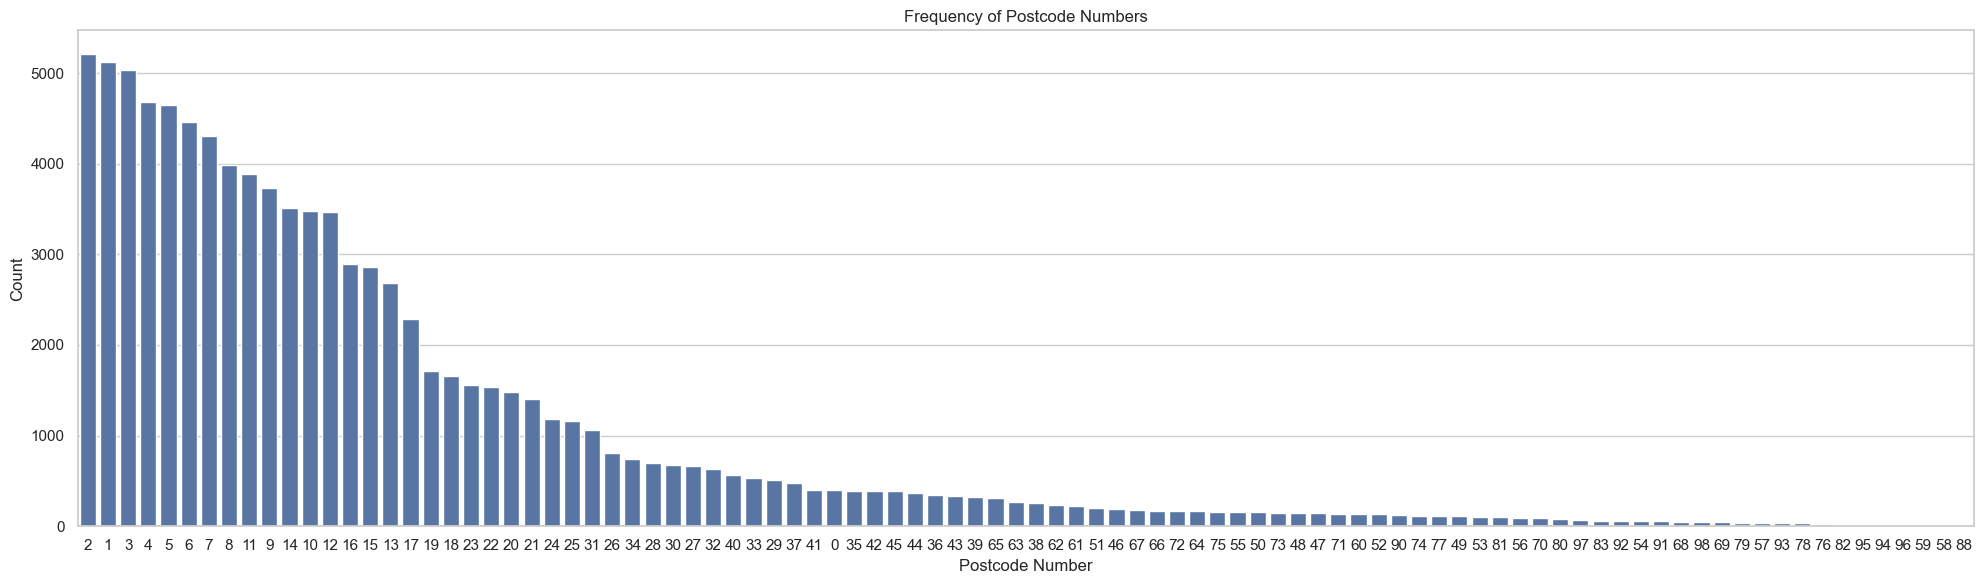

In [30]:
# Drop missing postcode_number values
df_filtered = df.dropna(subset=['postcode_number'])

# Convert postcode_number to integer for plotting (if it's not already)
df_filtered['postcode_number'] = df_filtered['postcode_number'].astype(int)

# Create the bar plot
plt.figure(figsize=(20, 6))
sns.countplot(x='postcode_number', data=df_filtered, order=df_filtered['postcode_number'].value_counts().index)

plt.title('Frequency of Postcode Numbers')
plt.xlabel('Postcode Number')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

Tukey's Honestly Significant Difference test compares all possible pairs of groups and tells you where the significant differences are.
True in the reject column:
→ The difference in means is statistically significant (p-value < 0.05 by default).
→ You can conclude the two groups have different average prices.
False in the reject column:
→ The difference in means is not statistically significant.
→ The groups may have different means, but the difference could be due to random chance.

In [31]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Drop missing values to avoid errors
df_clean = df[['price', 'property_type']].dropna()

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['price'],
                          groups=df_clean['property_type'],
                          alpha=0.05)

print(tukey)

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
     group1          group2        meandiff   p-adj      lower         upper     reject
---------------------------------------------------------------------------------------
       Detached Flat/Maisonette  -156975.0137    0.0  -197284.4118  -116665.6156   True
       Detached           Other   891246.2033    0.0    827029.122   955463.2846   True
       Detached   Semi-Detached  -166513.7084    0.0  -203624.9577  -129402.4591   True
       Detached        Terraced  -193006.0121    0.0  -230471.4335  -155540.5906   True
Flat/Maisonette           Other   1048221.217    0.0   982554.4495  1113887.9846   True
Flat/Maisonette   Semi-Detached    -9538.6947 0.9653   -49105.5452    30028.1558  False
Flat/Maisonette        Terraced   -36030.9983 0.0991   -75930.2294     3868.2327  False
          Other   Semi-Detached -1057759.9117    0.0 -1121513.5125  -994006.3109   True
          Other        Terraced 

In [32]:
df.drop(columns=['transaction_id'], inplace=True)

In [33]:
from scipy.stats import f_oneway

# List of categorical columns you want to test (adjust if needed)
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

for col in categorical_cols:
    # Ensure column is categorical
    df[col] = df[col].astype('category')
    
    # Extract price groups for each category
    groups = [df[df[col] == cat]['price'] for cat in df[col].cat.categories]
    
    # Run one-way ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    print(f"ANOVA results for '{col}':")
    print(f"F-statistic: {f_stat:.2f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"→ Statistically significant difference in mean prices across {col} categories.\n")
    else:
        print(f"→ No statistically significant difference in mean prices across {col} categories.\n")

ANOVA results for 'postcode':
F-statistic: 9.58
P-value: 0.0000
→ Statistically significant difference in mean prices across postcode categories.

ANOVA results for 'property_type':
F-statistic: 599.73
P-value: 0.0000
→ Statistically significant difference in mean prices across property_type categories.

ANOVA results for 'old_new':
F-statistic: 2.60
P-value: 0.1067
→ No statistically significant difference in mean prices across old_new categories.

ANOVA results for 'paon':
F-statistic: 2.01
P-value: 0.0000
→ Statistically significant difference in mean prices across paon categories.

ANOVA results for 'saon':
F-statistic: 6.14
P-value: 0.0000
→ Statistically significant difference in mean prices across saon categories.

ANOVA results for 'street':
F-statistic: 0.93
P-value: 1.0000
→ No statistically significant difference in mean prices across street categories.

ANOVA results for 'locality':
F-statistic: 1.24
P-value: 0.0000
→ Statistically significant difference in mean prices acro

That means the age category (old_new) does not have a meaningful impact on house prices in your dataset — the average prices are statistically similar across those categories.

## Log Transformation

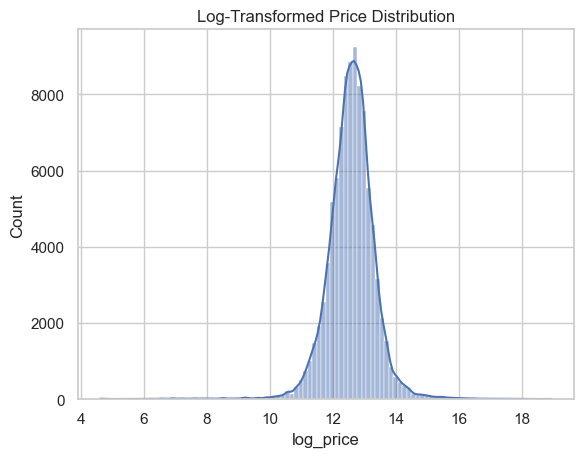

In [34]:
df['log_price'] = np.log1p(df['price'])  # log(1 + price)
sns.histplot(df['log_price'], bins=100, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.show()

## Handling Outliers

In [35]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
print(f"Original shape: {df.shape}, After removing outliers: {df_no_outliers.shape}")

Original shape: (93952, 31), After removing outliers: (88634, 31)


In [36]:
lower = df['price'].quantile(0.01)
upper = df['price'].quantile(0.99)

df['price_clipped'] = df['price'].clip(lower, upper)

## One hot encoding

In [37]:
df = df[df['price'] < 2_000_000]


from sklearn.preprocessing import LabelEncoder

# Make a copy of the DataFrame
df_encoded = df.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# List of columns to label encode
label_cols = [ 'town_city', 'district', 'county', 'property_type', 'record_status', 'ppd_category', 'old_new']

for col in label_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Done
print("Categorical encoding complete. Encoded columns:", label_cols)

Categorical encoding complete. Encoded columns: ['town_city', 'district', 'county', 'property_type', 'record_status', 'ppd_category', 'old_new']


In [38]:
# Show categorical columns including both 'object' and 'category' dtypes
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", list(categorical_cols))

Categorical columns: ['postcode', 'property_type', 'old_new', 'paon', 'saon', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category', 'record_status', 'paon_prefix', 'postcode_area']


In [39]:
df['flat_old'] = ((df['property_type'] == 'Flat') & (df['old_new'] == 'Old')).astype(int)
df['other_old'] = ((df['property_type'] == 'Other') & (df['old_new'] == 'Old')).astype(int)

df['flat_old'] = df['flat_old'].astype('category')
df['other_old'] = df['other_old'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93078 entries, 0 to 94247
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   price                   93078 non-null  int64         
 1   date_of_transfer        93078 non-null  datetime64[ns]
 2   postcode                93078 non-null  category      
 3   property_type           93078 non-null  category      
 4   old_new                 93078 non-null  category      
 5   paon                    93078 non-null  category      
 6   saon                    13497 non-null  category      
 7   street                  91615 non-null  category      
 8   locality                36104 non-null  category      
 9   town_city               93078 non-null  category      
 10  district                93078 non-null  category      
 11  county                  93078 non-null  category      
 12  ppd_category            93078 non-null  category   

In [40]:
df_encoded.drop(columns=['date_of_transfer', 'paon',  'county', 'duration', 'postcode', 'saon', 'street', 'locality', 'paon_length', 'paon_prefix', 'paon_starts_digit', 'paon_is_range', 'paon_number', 'paon_is_numeric', 'ppd_category'], inplace=True, errors='ignore')
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93078 entries, 0 to 94247
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   price                   93078 non-null  int64   
 1   property_type           93078 non-null  int64   
 2   old_new                 93078 non-null  int64   
 3   town_city               93078 non-null  int64   
 4   district                93078 non-null  int64   
 5   record_status           93078 non-null  int64   
 6   postcode_number         93078 non-null  float64 
 7   year                    93078 non-null  int32   
 8   month                   93078 non-null  int32   
 9   quarter                 93078 non-null  int32   
 10  day_of_week             93078 non-null  int32   
 11  is_new                  93078 non-null  int64   
 12  is_freehold             93078 non-null  int64   
 13  is_additional_property  93078 non-null  int64   
 14  paon_is_named           930

In [41]:
X = df_encoded.drop(columns=['price', 'log_price', 'price_clipped', 'postcode_number', 'postcode_area'])  # Features
y = df['price_clipped']   

## Fitting the model

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Polynomial transformation (e.g., degree=2)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'PolynomialRegression (deg=4)': LinearRegression()  # uses transformed data
}

# Fit and evaluate
for name, model in models.items():
    # Use polynomial-transformed data only for the PolynomialRegression model
    if 'PolynomialRegression' in name:
        model.fit(X_train_poly, y_train)
        preds = model.predict(X_test_poly)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"🔍 {name}")
    print(f"   MAE:  {mae:,.2f}")
    print(f"   RMSE: {rmse:,.2f}")
    print(f"   R²:   {r2:.4f}\n")


🔍 LinearRegression
   MAE:  153,406.46
   RMSE: 224,967.92
   R²:   0.1103

🔍 RandomForest
   MAE:  106,977.10
   RMSE: 173,389.75
   R²:   0.4715

🔍 GradientBoosting
   MAE:  129,364.16
   RMSE: 194,170.35
   R²:   0.3372

🔍 PolynomialRegression (deg=4)
   MAE:  153,495.66
   RMSE: 223,208.38
   R²:   0.1241



<Axes: ylabel='price'>

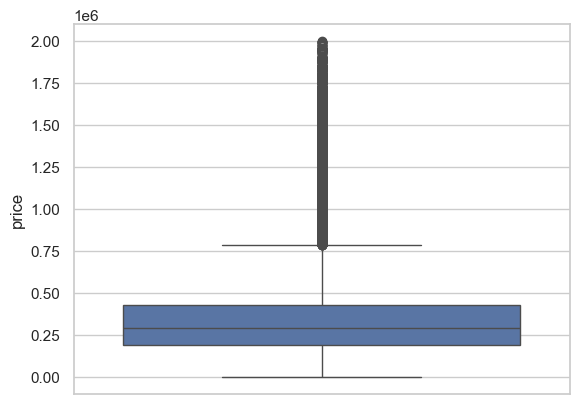

In [44]:
sns.boxplot(df['price'])

In [59]:
df = df[df['price'] < 2_000_000]  # or use quantile filtering

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 11.3925 - mae: 2.3225 - val_loss: 2.0560 - val_mae: 1.2528 - learning_rate: 0.0010
Epoch 2/200
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.3506 - mae: 0.9025 - val_loss: 0.4738 - val_mae: 0.5153 - learning_rate: 0.0010
Epoch 3/200
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4711 - mae: 0.5177 - val_loss: 0.2792 - val_mae: 0.3796 - learning_rate: 0.0010
Epoch 4/200
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2607 - mae: 0.3633 - val_loss: 0.1798 - val_mae: 0.2506 - learning_rate: 0.0010
Epoch 5/200
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.1827 - mae: 0.2948 - val_loss: 0.2208 - val_mae: 0.3423 - learning_rate: 0.0010
Epoch 6/200
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.1641 - mae: 0.2734 - val_loss: 0.1182 - val_mae: 0.1908 - learning_rate: 0.0010
Epoch 7/200
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1365 - mae: 0.2495 - val_loss: 0.1219 - val_mae: 0.2229 - l

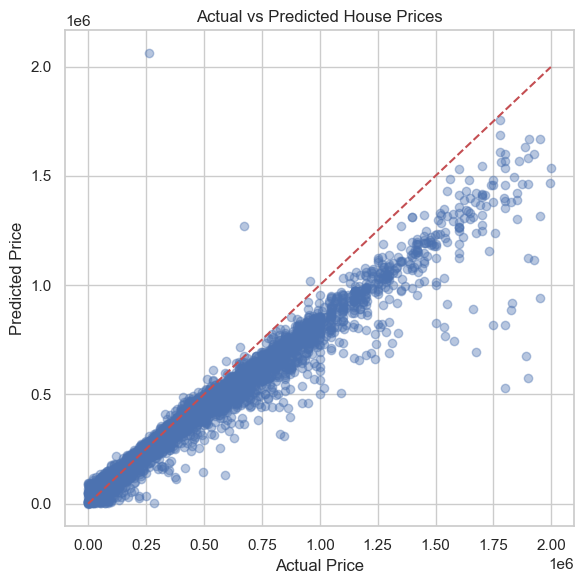

In [60]:
# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# --------------------------------------
# 🧹 Step 1: Preprocessing
# --------------------------------------

# Drop irrelevant columns
df_clean = df.drop(columns=[
    'transaction_id', 'date_of_transfer', 'paon', 'saon',
    'street', 'locality', 'postcode', 'record_status'
], errors='ignore')

# Drop rows with missing target
df_clean = df_clean.dropna(subset=['price'])

# Log-transform target
df_clean['log_price'] = np.log1p(df_clean['price'])

# Separate features and target
X = df_clean.drop(columns=['price', 'log_price'])
y = df_clean['log_price']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Fill any remaining NaNs (e.g., from rare categorical dummies) with 0
X = X.fillna(0)

# Split after filling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numeric input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------------------
# 🧠 Step 2: Neural Network Model
# --------------------------------------

nn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5
)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# --------------------------------------
# 📈 Step 3: Evaluation
# --------------------------------------

# Predict log(price) and revert back
nn_preds_log = nn_model.predict(X_test_scaled).flatten()
nn_preds = np.expm1(nn_preds_log)
y_test_actual = np.expm1(y_test)

# Check for NaNs
if np.isnan(nn_preds).all() or np.isnan(y_test_actual).all():
    print("❌ Cannot evaluate: All predictions or targets are NaN.")
else:
    mask = ~np.isnan(nn_preds) & ~np.isnan(y_test_actual)
    y_test_actual_clean = y_test_actual[mask]
    nn_preds_clean = nn_preds[mask]

    if len(y_test_actual_clean) == 0:
        print("❌ No valid samples left after filtering NaNs.")
    else:
        # ✅ Compute metrics
        mae = mean_absolute_error(y_test_actual_clean, nn_preds_clean)
        rmse = np.sqrt(mean_squared_error(y_test_actual_clean, nn_preds_clean))
        r2 = r2_score(y_test_actual_clean, nn_preds_clean)

        print("🔍 Neural Network Performance (NaN-safe)")
        print(f"   MAE:  £{mae:,.2f}")
        print(f"   RMSE: £{rmse:,.2f}")
        print(f"   R²:   {r2:.4f}")

        # Plot actual vs predicted
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test_actual_clean, nn_preds_clean, alpha=0.4)
        plt.plot(
            [y_test_actual_clean.min(), y_test_actual_clean.max()],
            [y_test_actual_clean.min(), y_test_actual_clean.max()],
            'r--'
        )
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.title("Actual vs Predicted House Prices")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Log-transform the target variable
y_train_log = np.log1p(y_train)  # log1p = log(1 + x)
y_test_log = np.log1p(y_test)

# 2. Scale your input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Define the neural network model
nn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])


# 4. Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 5. Early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6. Fit the model using log(price)
history = nn_model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# 7. Predict log(price), then revert to original scale
nn_preds_log = nn_model.predict(X_test_scaled).flatten()
nn_preds = np.expm1(nn_preds_log)  # Convert back to price scale

# 8. Evaluate against actual (non-log) y_test
mae = mean_absolute_error(y_test, nn_preds)
rmse = np.sqrt(mean_squared_error(y_test, nn_preds))
r2 = r2_score(y_test, nn_preds)

print("🔍 Neural Network (Predicting log(price), reporting actual scale)")
print(f"   MAE:  {mae:,.2f}")
print(f"   RMSE: {rmse:,.2f}")
print(f"   R²:   {r2:.4f}\n")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🔍 Neural Network (Predicting log(price), reporting actual scale)
   MAE:  148,482.45
   RMSE: 259,053.48
   R²:   0.1489



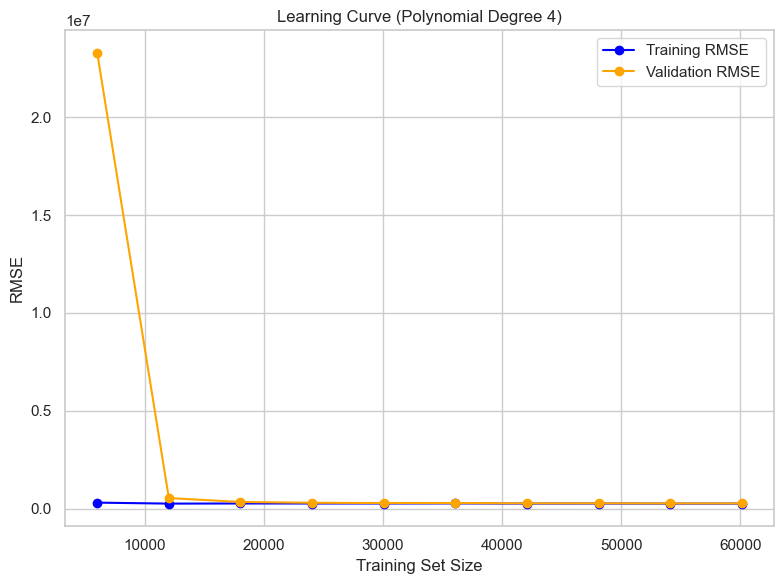

In [44]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline: PolynomialFeatures + LinearRegression
degree = 4  # or any degree you like
model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), LinearRegression())

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Compute average and std
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.sqrt(train_errors), 'o-', label='Training RMSE', color='blue')
plt.plot(train_sizes, np.sqrt(val_errors), 'o-', label='Validation RMSE', color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title(f'Learning Curve (Polynomial Degree {degree})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# --- Random Forest hyperparameter tuning ---

rf = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [None, 10, 20, 30],     # Maximum depth of trees
    'min_samples_split': [2, 5, 10],     # Minimum samples to split node
    'min_samples_leaf': [1, 2, 4]        # Minimum samples at leaf node
}

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, 
                       cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

rf_grid.fit(X_train, y_train)

print("Best Random Forest params:", rf_grid.best_params_)
print("Best RF MAE:", -rf_grid.best_score_)

# --- Gradient Boosting hyperparameter tuning ---

gb = GradientBoostingRegressor(random_state=42)

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_grid = GridSearchCV(estimator=gb, param_grid=gb_param_grid, 
                       cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

gb_grid.fit(X_train, y_train)

print("Best Gradient Boosting params:", gb_grid.best_params_)
print("Best GB MAE:", -gb_grid.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Random Forest params: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best RF MAE: 118756.5881924602
Fitting 3 folds for each of 243 candidates, totalling 729 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best GB MAE: 113944.97395239341
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  35.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  38.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  38.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.8min
[CV] 

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train the Random Forest model with best parameters
best_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
best_rf.fit(X_train, y_train)

# Predict on test data
y_pred = best_rf.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Show results
print("🔍 Tuned Random Forest")
print(f"   MAE:  {mae:,.2f}")
print(f"   RMSE: {rmse:,.2f}")
print(f"   R²:   {r2:.4f}")


🔍 Tuned Random Forest
   MAE:  115,612.19
   RMSE: 202,488.85
   R²:   0.4800


In [114]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train the Gradient Boosting model with best parameters
best_gb = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42
)

# Fit the model
best_gb.fit(X_train, y_train)

# Predict on test data
y_pred = best_gb.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Show results
print("🔍 Tuned Gradient Boosting")
print(f"   MAE:  {mae:,.2f}")
print(f"   RMSE: {rmse:,.2f}")
print(f"   R²:   {r2:.4f}")

🔍 Tuned Gradient Boosting
   MAE:  111,721.50
   RMSE: 195,344.85
   R²:   0.5161


In [108]:
importances = model.feature_importances_
features = X_train.columns

/var/folders/g3/hwwd8nzx1s1g8p458ygp9p500000gn/T/ipykernel_63840/600533712.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


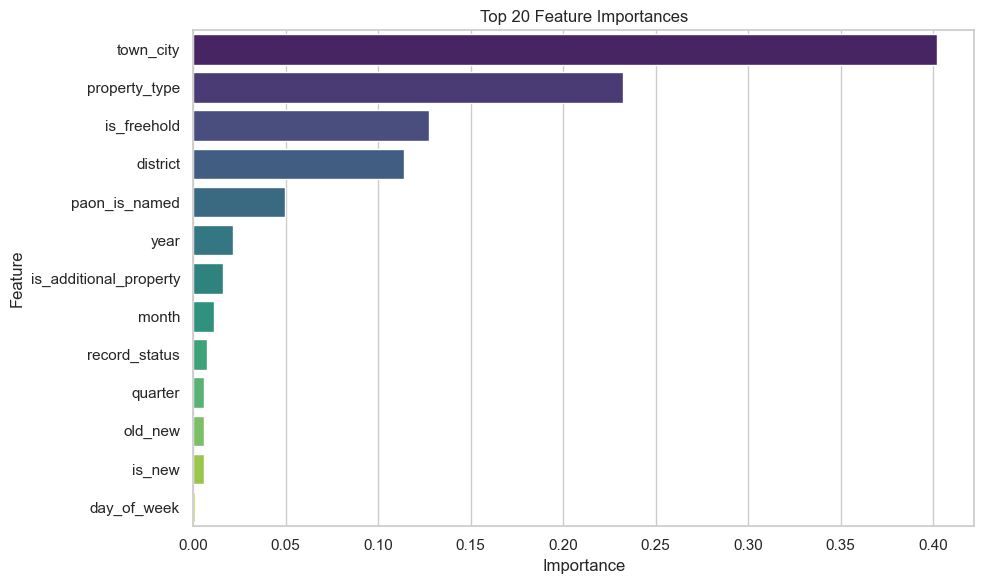

In [109]:
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [110]:
import joblib

# Save the Random Forest model
joblib.dump(best_rf, 'random_forest_model.pkl')

# Save the Gradient Boosting model
joblib.dump(best_gb, 'gradient_boosting_model.pkl')

print("Models saved successfully.")


Models saved successfully.


In [111]:
# Load Random Forest model
loaded_rf = joblib.load('random_forest_model.pkl')

# Load Gradient Boosting model
loaded_gb = joblib.load('gradient_boosting_model.pkl')
